# Seq2Seq using MXNet Gluon

## Different types of RNN

![](rnn_types.jpeg)

## Seq2Seq network

![](seq2seq.png)

## Seq2Seq network with attention

![](seq2seq_attention.png)

In [1]:
from __future__ import unicode_literals

import argparse
import random
import unicodedata
import string
import re

import numpy as np
import mxnet as mx
from io import open
from mxnet import gluon, autograd, nd
from mxnet.gluon import nn, rnn, Block

/home/ubuntu/.local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
num_iters = 220000
lr = 0.01
max_length = 10
num_layers = 1
hidden_size = 256
teacher_forcing_ratio = 0.5
log_interval = 5000
test = True

In [3]:
SOS_token = 0
EOS_token = 1

ctx = mx.gpu(0)

In [4]:
class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )


# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filterPair(p, max_length):
    return len(p[0].split(' ')) < max_length and \
        len(p[1].split(' ')) < max_length and \
        p[1].startswith(eng_prefixes)

def filterPairs(pairs, max_length):
    return [pair for pair in pairs if filterPair(pair, max_length)]

def prepareData(lang1, lang2, max_length, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs, max_length)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

In [5]:
input_lang, output_lang, pairs = prepareData('eng', 'fra', max_length, True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 10853 sentence pairs
Counting words...
Counted words:
fra 4489
eng 2925
['vous me decevez .', 'i m disappointed in you .']


In [6]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def variableFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    result = nd.array(indexes)
    return result

def variablesFromPair(pair):
    input_variable = variableFromSentence(input_lang, pair[0])
    target_variable = variableFromSentence(output_lang, pair[1])
    return (input_variable, target_variable)

![](code1.png)

In [7]:
class EncoderRNN(Block):
    def __init__(self, input_size, hidden_size, n_layers):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers

        with self.name_scope():
            self.embedding = nn.Embedding(input_size, hidden_size)
            self.gru = rnn.GRU(hidden_size, input_size=self.hidden_size)

    def forward(self, input, hidden):
        output = self.embedding(input).swapaxes(0, 1)
        for i in range(self.n_layers):
            output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self, ctx):
        return [nd.zeros((1, 1, self.hidden_size), ctx=ctx)]

In [8]:
class AttnDecoderRNN(Block):
    def __init__(self, hidden_size, output_size, n_layers, max_length, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout_p = dropout_p
        self.max_length = max_length

        with self.name_scope():
            self.embedding = nn.Embedding(self.output_size, self.hidden_size)
            self.attn = nn.Dense(self.max_length, in_units=self.hidden_size * 2)
            self.attn_combine = nn.Dense(self.hidden_size, in_units=self.hidden_size * 2)
            if self.dropout_p > 0:
                self.dropout = nn.Dropout(self.dropout_p)
            self.gru = rnn.GRU(self.hidden_size, input_size=self.hidden_size)
            self.out = nn.Dense(self.output_size, in_units=self.hidden_size)

    def forward(self, input, hidden, encoder_outputs):
        
        # Input shape is 1. Just a scalar. Examples of input: [0], [213], [23], [76]

        # Hidden is a list because LSTMs could be stacked.
        # Hidden[0] is the hidden state of the first LSTM
        # Shape of Hidden[0] is (1, 1, 256)

        # encoder_outputs is a (10, 256) tensor
        
        # embedded is a (1, 256) tensor
        embedded = self.embedding(input)

        # Dropout for regularization
        if self.dropout_p > 0:
            embedded = self.dropout(embedded)

        # Depending on the hidden state and the input, predict attention weights.
        # self.attn is a dense layer.
        # attn_weights is a (1, 10) vector - one scalar for each time step in the input.
        attn_weights = nd.softmax(
            self.attn(nd.concat(embedded, hidden[0].flatten(), dim=1)))
        
        
        # attn_weights is (1, 10)
        # encoder_outputs is (10, 256)
        # attn_applied is (1, 1, 256)
        attn_applied = nd.batch_dot(attn_weights.expand_dims(0),
                                 encoder_outputs.expand_dims(0))
        
        # Combine current input to decoder and attn_applied to input seq into one tensor
        output = nd.concat(embedded.flatten(), attn_applied.flatten(), dim=1)
        # Pass it through a dense layer to get a (1, 1, 256) tensor
        output = self.attn_combine(output).expand_dims(0)

        # pass output and hidden through GRU
        for i in range(self.n_layers):
            output = nd.relu(output)
            output, hidden = self.gru(output, hidden)

        # Final dense layer to create the output
        output = self.out(output)

        return output, hidden, attn_weights

    def initHidden(self, ctx):
        return [nd.zeros((1, 1, self.hidden_size), ctx=ctx)]

In [9]:
def train(input_variable, target_variable, encoder, decoder, teacher_forcing_ratio,
          encoder_optimizer, decoder_optimizer, criterion, max_length, ctx):
    with autograd.record():
        loss = nd.zeros((1,), ctx=ctx)

        encoder_hidden = encoder.initHidden(ctx)

        input_length = input_variable.shape[0]
        target_length = target_variable.shape[0]

        encoder_outputs, encoder_hidden = encoder(
                input_variable.expand_dims(0), encoder_hidden)

        if input_length < max_length:
            encoder_outputs = nd.concat(encoder_outputs.flatten(),
                nd.zeros((max_length - input_length, encoder.hidden_size), ctx=ctx), dim=0)
        else:
            encoder_outputs = encoder_outputs.flatten()



        decoder_input = nd.array([SOS_token], ctx=ctx)

        decoder_hidden = encoder_hidden

        use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

        if use_teacher_forcing:
            # Teacher forcing: Feed the target as the next input
            for di in range(target_length):
                decoder_output, decoder_hidden, decoder_attention = decoder(
                    decoder_input, decoder_hidden, encoder_outputs)

                loss = nd.add(loss, criterion(decoder_output, target_variable[di]))
                #print criterion(decoder_output, target_variable[di])
                decoder_input = target_variable[di]  # Teacher forcing

        else:
            # Without teacher forcing: use its own predictions as the next input
            for di in range(target_length):
                decoder_output, decoder_hidden, decoder_attention = decoder(
                    decoder_input, decoder_hidden, encoder_outputs)
                topi = decoder_output.argmax(axis=1)

                decoder_input = nd.array([topi.asscalar()], ctx=ctx)

                loss = nd.add(loss, criterion(decoder_output, target_variable[di]))

                if topi.asscalar() == EOS_token:
                    break

        loss.backward()

    encoder_optimizer.step(1)
    decoder_optimizer.step(1)

    return loss.asscalar()/target_length

In [13]:
def trainIters(encoder, decoder, ctx):
    #start = time.time()
    #plot_losses = []
    print_every = log_interval
    print_loss_total = 0  # Reset every print_every

    encoder.initialize(ctx=ctx)
    decoder.initialize(ctx=ctx)

    encoder_optimizer = gluon.Trainer(encoder.collect_params(), 'sgd', {'learning_rate': lr})
    decoder_optimizer = gluon.Trainer(decoder.collect_params(), 'sgd', {'learning_rate': lr})

    training_pairs = [variablesFromPair(random.choice(pairs))
                      for i in range(num_iters)]

    criterion = gluon.loss.SoftmaxCrossEntropyLoss()

    for iter in range(1, num_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_variable = training_pair[0].as_in_context(ctx)
        target_variable = training_pair[1].as_in_context(ctx)

        loss = train(input_variable, target_variable, encoder, decoder, teacher_forcing_ratio,
                     encoder_optimizer, decoder_optimizer, criterion, max_length, ctx)

        print_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print("Iter: %d, Loss: %f" % (iter, print_loss_avg))
            
        

In [14]:
encoder = EncoderRNN(input_lang.n_words, hidden_size, num_layers)
attn_decoder = AttnDecoderRNN(hidden_size, output_lang.n_words,
                               num_layers, max_length, dropout_p=0.1)

In [15]:
trainIters(encoder, attn_decoder, ctx)

Iter: 5000, Loss: 3.241804
Iter: 10000, Loss: 2.801264
Iter: 15000, Loss: 2.616214
Iter: 20000, Loss: 2.463293
Iter: 25000, Loss: 2.334231
Iter: 30000, Loss: 2.215919
Iter: 35000, Loss: 2.073867
Iter: 40000, Loss: 1.938917
Iter: 45000, Loss: 1.864805
Iter: 50000, Loss: 1.784869
Iter: 55000, Loss: 1.706256
Iter: 60000, Loss: 1.592537
Iter: 65000, Loss: 1.488486
Iter: 70000, Loss: 1.442711
Iter: 75000, Loss: 1.363164
Iter: 80000, Loss: 1.305546
Iter: 85000, Loss: 1.218956
Iter: 90000, Loss: 1.175147
Iter: 95000, Loss: 1.049850
Iter: 100000, Loss: 1.050144
Iter: 105000, Loss: 1.007301
Iter: 110000, Loss: 0.943417
Iter: 115000, Loss: 0.890869
Iter: 120000, Loss: 0.830606
Iter: 125000, Loss: 0.839308
Iter: 130000, Loss: 0.752628
Iter: 135000, Loss: 0.722229
Iter: 140000, Loss: 0.712379
Iter: 145000, Loss: 0.653361
Iter: 150000, Loss: 0.630558
Iter: 155000, Loss: 0.618550
Iter: 160000, Loss: 0.572765
Iter: 165000, Loss: 0.569241
Iter: 170000, Loss: 0.546061
Iter: 175000, Loss: 0.502664
Iter:

In [16]:
def evaluate(encoder, decoder, sentence, max_length=max_length):
    input_tensor = variableFromSentence(input_lang, sentence).as_in_context(ctx)
    input_length = input_tensor.shape[0]
    print(input_length)
    
    encoder_hidden = encoder.initHidden(ctx)


    encoder_outputs = nd.zeros((max_length, encoder.hidden_size), ctx=ctx)


    for ei in range(input_length):
        
        encoder_output, encoder_hidden = encoder(input_tensor[ei].expand_dims(0),
                                                 encoder_hidden)
        encoder_outputs[ei] += encoder_output[0, 0]
        
    decoder_input = nd.array([SOS_token], ctx=ctx)

    decoder_hidden = encoder_hidden

    decoded_words = []
    decoder_attentions = nd.zeros((max_length, max_length), ctx=ctx)

    for di in range(max_length):
        decoder_output, decoder_hidden, decoder_attention = decoder(
            decoder_input, decoder_hidden, encoder_outputs)
        decoder_attentions[di] = decoder_attention
        
        topi = nd.argmax(decoder_output, axis=1)
        
        if topi.asscalar() == EOS_token:
            decoded_words.append('<EOS>')
            break
        else:
            decoded_words.append(output_lang.index2word[topi.asscalar()])

        decoder_input = topi

    return decoded_words, decoder_attentions[:di + 1]

In [19]:
pair = random.choice(pairs)
print(pair)
evaluate(encoder, attn_decoder, pair[0], 10)

['je suis en bas .', 'i m downstairs .']
6


(['i', 'm', 'downstairs', '.', '<EOS>'], 
 [[3.53245327e-04 9.94926333e-01 4.34153946e-03 1.15865498e-06
   6.46358967e-05 2.01082512e-05 4.03172635e-06 7.80339803e-07
   2.80976645e-04 7.06006040e-06]
  [9.53751411e-10 4.04205380e-09 1.49591165e-06 9.99992728e-01
   5.53581594e-06 1.71412926e-10 8.25986720e-15 1.55355687e-10
   1.28140456e-07 1.56093719e-07]
  [2.35156727e-10 4.34673023e-17 4.40854471e-12 7.41146735e-08
   1.44712715e-07 9.99999762e-01 5.11501377e-13 1.02461605e-16
   6.48014715e-12 5.91358629e-10]
  [1.97000048e-07 3.85390504e-14 4.00942925e-11 1.80393917e-16
   8.65569394e-09 6.18776275e-09 9.99999762e-01 1.20949528e-10
   2.76330998e-12 8.97970587e-11]
  [4.19353174e-09 8.40451389e-11 2.62951466e-10 9.48485804e-11
   3.43347378e-10 3.36677322e-15 5.11777642e-09 9.99999881e-01
   6.18599247e-13 5.99967720e-08]]
 <NDArray 5x10 @gpu(0)>)

10
input = elle a cinq ans de moins que moi .
output = she s six years younger than i am . <EOS>


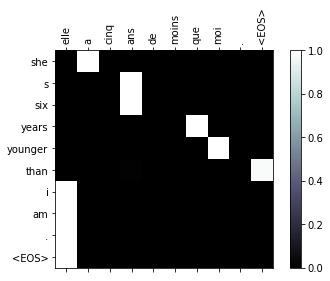

6
input = elle est trop petit .
output = she s too loud . <EOS>


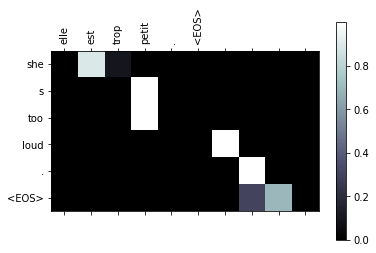

8
input = je ne crains pas de mourir .
output = i m not afraid to die . <EOS>


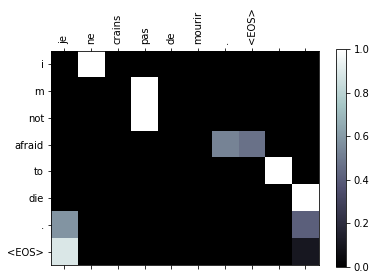

10
input = c est un jeune directeur plein de talent .
output = he s a nervous young great . <EOS>


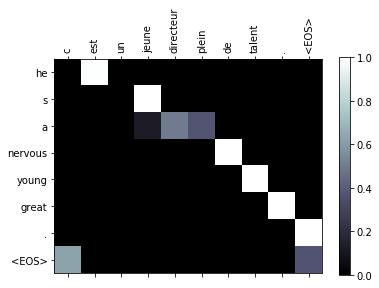

In [20]:
%matplotlib inline

import matplotlib.pyplot as plt
#plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)


def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.asnumpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder, attn_decoder, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("elle a cinq ans de moins que moi .")

evaluateAndShowAttention("elle est trop petit .")

evaluateAndShowAttention("je ne crains pas de mourir .")

evaluateAndShowAttention("c est un jeune directeur plein de talent .")